# Wilson's Morning Wake Up Playlist Generator, Modeling and Learning

## CPU Only

The following steps will be executed:

* Upload your data to S3.
* Define a benchmark and candidate models and training scripts
* Train models and deploy.
* Evaluate deployed estimator.

In [10]:
# Defaults
import os
import sys

import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
from sklearn.externals import joblib

import torch

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from mpl_toolkits import mplot3d

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# import boto3
# import sagemaker

In [ ]:
# # session and role
# sagemaker_session = sagemaker.Session()
# role = sagemaker.get_execution_role()

# # create an S3 bucket
# bucket = sagemaker_session.default_bucket()

In [11]:
!ls -la data

'ls' is not recognized as an internal or external command,
operable program or batch file.


## Upload your training data to S3

In [12]:
# should be the name of directory you created to save your features data
data_dir = 'data'

In [129]:
# # set prefix, a descriptive name for a directory  
# prefix = 'sagemaker/wmw_estimator'

# # upload all data to S3
# input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

---

# Modeling

It's time to define and train the models!

---

## Complete a training script 

To implement a custom estimator, I need to complete a `train.py` script. 

A typical training script:
* Loads training data from a specified directory
* Parses any training & model hyperparameters (ex. nodes in a neural network, training epochs, etc.)
* Instantiates a model of your design, with any specified hyperparams
* Trains that model 
* Finally, saves the model so that it can be hosted/deployed, later

### Defining and training a model

To complete a `train.py` file, you will:
1. Import any extra libraries you need
2. Define any additional model training hyperparameters using `parser.add_argument`
2. Define a model in the `if __name__ == '__main__':` section
3. Train the model in that same section


In [130]:
# Directory of train.py
!pygmentize model/train.py

Error: cannot read infile: [Errno 2] No such file or directory: 'model/train.py'


---
# Create an Estimator

When a custom model is constructed in SageMaker, an entry point must be specified. This is the Python file which will be executed when the model is trained; the `train.py` function you specified above. To run a custom training script in SageMaker, construct an estimator, and fill in the appropriate constructor arguments:

* **entry_point**: The path to the Python script SageMaker runs for training and prediction.
* **source_dir**: The path to the training script directory `source_sklearn` OR `source_pytorch`.
* **entry_point**: The path to the Python script SageMaker runs for training and prediction.
* **source_dir**: The path to the training script directory `train_sklearn` OR `train_pytorch`.
* **entry_point**: The path to the Python script SageMaker runs for training.
* **source_dir**: The path to the training script directory `train_sklearn` OR `train_pytorch`.
* **role**: Role ARN, which was specified, above.
* **train_instance_count**: The number of training instances (should be left at 1).
* **train_instance_type**: The type of SageMaker instance for training. Note: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* **sagemaker_session**: The session used to train on Sagemaker.
* **hyperparameters** (optional): A dictionary `{'name':value, ..}` passed to the train function as hyperparameters.

Note: For a PyTorch model, there is another optional argument **framework_version**, which you can set to the latest version of PyTorch, `1.0`.

## Define PyTorch estimators

In [131]:
# Build sequences and targets
def create_playlist_sequences(input_data):
    input_playlists = []
    
    for i in input_data['volume'].unique():
        temp_vol = input_data[input_data['volume'] == i]
        X = temp_vol.iloc[:, 2:11].values
        y = temp_vol.iloc[:, 11:].values
        input_playlists.append((X, y))
        
    return input_playlists

In [132]:
from unittest.mock import MagicMock, patch

def _print_success_message():
    print('Tests Passed!')

def test_playlist_sequences(input_playlists):
    
    track_features = [-2.39099487, -2.63509459, -0.27732204,  0.92969533, -0.48983686,-1.15691947,  1.08569029, -1.20454903,  2.09618458, -5.37044178, 0.23380331]
    
    track_features_len = 11
    target_features_len = 8
    
    # check shape and equality of first track
    assert len(input_playlists[0][0][0]) == len(track_features), \
        'Number of features in input_playlist features does not match expected number of ' + str(len(track_features))    
    
    # check shape of input and output arrays
    assert input_playlists[0][0].shape[1]==track_features_len, \
        'input_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
    assert input_playlists[0][1].shape[1]==target_features_len, \
        'target_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
    
    #TODO: Add more tests
    
    _print_success_message()

### Test run of benchmark and candidate models and train components
Here I will see if the configurations I have set work accordingly with no errors. Once it runs smoothly, I will instantiate an estimator using the Sagemaker API.

In [13]:
import os
import torch
import torch.utils.data

train_data = pd.read_csv(os.path.join(data_dir, "train.csv"))

# Gather sequences and targets
processed_data = create_playlist_sequences(train_data)

NameError: name 'create_playlist_sequences' is not defined

In [288]:
from torch.utils.data import Dataset
import torch

class PlaylistDataset(Dataset):
    def __init__(self, data_dir, csv_path):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Read the csv file
        self.data = pd.read_csv(os.path.join(data_dir, csv_path))
        # First column contains the image paths
        self.data_arr = self.data.iloc[:, 2:11].values
        # Second column is the labels
        self.label_arr = self.data.iloc[:, 11:].values
        # Calculate len
        self.data_len = len(self.data.index)

    def __getitem__(self, index):
        # Get track
        single_track = torch.from_numpy(self.data_arr[index]).float()
        
        # Get label(class) of the image based on the cropped pandas column
        single_target = torch.from_numpy(self.label_arr[index]).float()

        return (single_track, single_target)

    def __len__(self):
        return self.data_len

if __name__ == "__main__":
    # Call dataset
    dataset = PlaylistDataset('data', "tensor_train_df.csv")

    dataloader = DataLoader(dataset, batch_size=12, shuffle=False)
    print(next(iter(dataloader)))

TypeError: 'list' object is not an iterator

In [ ]:
dataset =  PlaylistDataset('data', "tensor_train_df.csv")

dataloader = DataLoader(dataset, batch_size=12, shuffle=False)

In [330]:
# Training function for LSTM
def train_lstm(model, train_loader, epochs, criterion, optimizer, device):
    """
    This is the training method that is called by the PyTorch training script of the LSTM model. The parameters
    passed are as follows:
    model        - The PyTorch model that we wish to train.
    train_loader - The PyTorch DataLoader that should be used during training.
    epochs       - The total number of epochs to train for.
    criterion    - The loss function used for training. 
    optimizer    - The optimizer to use during training.
    device       - Where the model and data should be loaded (gpu or cpu).
    """
    
    model.train() # Make sure that the model is in training mode.
    
    # training loop is provided
    for epoch in range(1, epochs + 1):
        
        for i, batch in enumerate(train_loader):

            optimizer.zero_grad()

            cum_loss = 0
            
            for i, track in enumerate(batch):
                
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_dim), torch.zeros(1, 1, model.hidden_layer_dim))                

                track_x = track[0]
                track_y = track[-1]
                
                output = model(track_x.unsqueeze(0))
                
                loss = criterion(output, track_y)
                loss.backward()
                optimizer.step()
                cum_loss += loss.data.item()

            total_loss = cum_loss / len(batch[0])
            
        if epoch % 100 == 0:
            print('Epoch: {}/{}.............'.format(epoch, epochs), end=' ')
            print("Loss: {:.4f}".format(total_loss))

In [333]:
import torch.optim as optim
from model.LSTM_Estimator import LSTMEstimator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTMEstimator(9, 30, 1, 9)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
loss_fn = torch.nn.L1Loss()

train_lstm(lstm_model, dataloader, 1500, loss_fn, optimizer, device)

Epoch: 100/1500............. Loss: 0.1161
Epoch: 200/1500............. Loss: 0.0998
Epoch: 300/1500............. Loss: 0.0976
Epoch: 400/1500............. Loss: 0.0985
Epoch: 500/1500............. Loss: 0.0890
Epoch: 600/1500............. Loss: 0.0883
Epoch: 700/1500............. Loss: 0.0831
Epoch: 800/1500............. Loss: 0.0813
Epoch: 900/1500............. Loss: 0.0776
Epoch: 1000/1500............. Loss: 0.0751
Epoch: 1100/1500............. Loss: 0.0713
Epoch: 1200/1500............. Loss: 0.0681
Epoch: 1300/1500............. Loss: 0.0651
Epoch: 1400/1500............. Loss: 0.0622
Epoch: 1500/1500............. Loss: 0.0550


In [337]:
# Save LSTM
torch.save(lstm_model.state_dict(), 'artefacts/lstm_model.pth')

In [289]:
class RNNEstimator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNEstimator, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) 
        self.i2o = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, inp, hidden):
        combined = torch.cat((inp, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [328]:
# Training function for RNN
def train_rnn(model, dataloader, epochs, criterion, optimizer, device):
    
    model.train() # Make sure that the model is in training mode.
    
    for epoch in range(1, epochs + 1):

        for i, batch in enumerate(dataloader):
            
            cum_loss = 0
            
            hidden = model.initHidden()
            
            optimizer.zero_grad()
        
            for i, track in enumerate(batch):

                track_x = track[0]
                track_y = track[-1]
                
                output, hidden = model(track_x.unsqueeze(0), hidden)
            
                loss = criterion(output, track_y)
                loss.backward()
                optimizer.step()
                cum_loss += loss.data.item()
                
            total_loss = cum_loss / len(batch[0])

        if epoch % 100 == 0:
            print('Epoch: {}/{}.............'.format(epoch, epochs), end=' ')
            print("Loss: {:.4f}".format(total_loss))

In [339]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model = RNNEstimator(9, 30, 9)
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
loss_fn = torch.nn.L1Loss()

train_rnn(rnn_model, dataloader, 1500, loss_fn, optimizer, device)

Epoch: 100/1500............. Loss: 0.1807
Epoch: 200/1500............. Loss: 0.1731
Epoch: 300/1500............. Loss: 0.1728
Epoch: 400/1500............. Loss: 0.1711
Epoch: 500/1500............. Loss: 0.1725
Epoch: 600/1500............. Loss: 0.1729
Epoch: 700/1500............. Loss: 0.1741
Epoch: 800/1500............. Loss: 0.1735
Epoch: 900/1500............. Loss: 0.1736
Epoch: 1000/1500............. Loss: 0.1718
Epoch: 1100/1500............. Loss: 0.1741
Epoch: 1200/1500............. Loss: 0.1742
Epoch: 1300/1500............. Loss: 0.1740
Epoch: 1400/1500............. Loss: 0.1734
Epoch: 1500/1500............. Loss: 0.1712


In [338]:
# Save RNN
torch.save(model.state_dict(), 'artefacts/rnn_model.pth')

In [92]:
# Spotify API
import spotipy
import spotipy.util as util

# Spotify for developers client auth variables
username = os.environ['SPOTIFY_EMAIL']
spotify_id = os.environ['SPOTIFY_ID']
spotify_secret = os.environ['SPOTIFY_SECRET']

# Set API scope
scope='playlist-read-private, playlist-modify-private, playlist-modify-public'

# Get auth token
token = util.prompt_for_user_token(username, 
                                   scope,
                                   client_id=spotify_id,
                                   client_secret=spotify_secret,
                                   redirect_uri='http://localhost/')

In [93]:
from spotipy.oauth2 import SpotifyClientCredentials

#Authenticate
sp = spotipy.Spotify(
    client_credentials_manager = SpotifyClientCredentials(
        client_id=spotify_id,
        client_secret=spotify_secret
    )
)

In [14]:
# Read in WMW tracks to date for recommendations
track_data = pd.read_csv(os.path.join(data_dir, "wmw_tracks.csv"))

track_data.head()

,volume,position,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,38,1,Finding It There,Goldmund,0.187,0.00257,1,-37.134,1,0.0427,...,0.0915,0.0374,123.707,audio_features,6CnPCuUcM3A5PMP4gUy0vw,spotify:track:6CnPCuUcM3A5PMP4gUy0vw,https://api.spotify.com/v1/tracks/6CnPCuUcM3A5...,https://api.spotify.com/v1/audio-analysis/6CnP...,220120,5
1,38,2,Light Forms,Rohne,0.671,0.54500,10,-12.848,0,0.0393,...,0.1180,0.2840,133.036,audio_features,6MkUPsz5hYeneo0a9H0VT8,spotify:track:6MkUPsz5hYeneo0a9H0VT8,https://api.spotify.com/v1/tracks/6MkUPsz5hYen...,https://api.spotify.com/v1/audio-analysis/6MkU...,265870,4
2,38,3,C-Side,Khruangbin,0.688,0.77900,11,-10.129,0,0.0579,...,0.3490,0.9380,94.073,audio_features,6GvAM8oyVApQHGMgpBt8yl,spotify:track:6GvAM8oyVApQHGMgpBt8yl,https://api.spotify.com/v1/tracks/6GvAM8oyVApQ...,https://api.spotify.com/v1/audio-analysis/6GvA...,283407,4
3,38,4,Didn't I (Dave Allison Rework),Darondo,0.539,0.70500,0,-6.729,1,0.0527,...,0.1330,0.6850,186.033,audio_features,1owjOeZt1BdYWW6T8fIAEe,spotify:track:1owjOeZt1BdYWW6T8fIAEe,https://api.spotify.com/v1/tracks/1owjOeZt1BdY...,https://api.spotify.com/v1/audio-analysis/1owj...,328000,4
4,38,5,Woman Of The Ghetto - Akshin Alizadeh Remix,Marlena Shaw,0.707,0.57300,7,-8.403,0,0.0276,...,0.0858,0.1890,100.006,audio_features,2h8cQH7zhUWrynZi2MKhhC,spotify:track:2h8cQH7zhUWrynZi2MKhhC,https://api.spotify.com/v1/tracks/2h8cQH7zhUWr...,https://api.spotify.com/v1/audio-analysis/2h8c...,302467,4


In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

pca.fit(track_data[feature_list])

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[9.49632173e-01 4.97587396e-02 2.33959882e-04]
[491.49839801 112.50688028   7.71462986]


In [74]:
#TODO- Save StandarScaler for later us
from pickle import dump

# save the scaler
dump(pca, open('artefacts/dim_red.pkl', 'wb'))

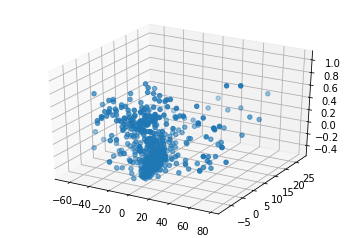

In [73]:
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df[:,0], pca_df[:,1], pca_df[:,2])
plt.show()

In [71]:
pca_df = pca.transform(track_data[feature_list])

array([[ 4.36220894e+00,  2.62242177e+01,  2.20013556e-01],
       [ 1.39826515e+01,  2.04964369e+00, -1.09662254e-01],
       [-2.49435282e+01, -1.19130395e+00,  3.81116247e-01],
       ...,
       [ 3.71216192e-02, -5.30568973e+00,  3.97253658e-01],
       [ 9.97438835e-01, -3.96836317e+00, -2.24355491e-01],
       [ 8.99963313e+00, -1.80496344e+00, -4.41656957e-03]])

In [96]:
import random
from tqdm.notebook import tqdm
import joblib
import torch.optim as optim

from model.LSTM_Estimator import LSTMEstimator
from model.RNN_Estimator import RNNEstimator


class Playlist():
    def __init__(self, wmw_pool, model_type="LSTM"):
        self.recommended_track_ids = pd.DataFrame() #list of track ids straight from spotify
        self.trax = [] #all tracks as dict
        self.df = None #this is where the data goes
        self.playlist = None
        self.wmw_pool_df = wmw_pool
        
        # Feature set
        self.feature_list =  ['danceability','energy', 'loudness', 'speechiness', 'acousticness',
                         'instrumentalness', 'liveness', 'valence', 'tempo']
    
        # Setup feature standardisation
        self.std_scaler = joblib.load('artefacts/standard_features.pkl')
        
        # Setup dimensionality reduction for track picking
        self.dim_red = joblib.load('artefacts/dim_red.pkl')
        
        if model_type == "LSTM":
            model = LSTMEstimator(9, 30, 1, 9)
            model.load_state_dict(torch.load('artefacts/lstm_model.pth'))
            
        elif model_type == "RNN":
            model = RNNEstimator(9, 30, 9)
            model.load_state_dict(torch.load('artefacts/rnn_model.pth'))
        else:
            print("Please specify either the RNN or LSTM model using the model_type parameter.")
        
        model.eval()
        
        # Start building the new playlist
        self.intro_track = self.get_first_track()
        self.new_playlist = self.predict_playlist(model, self.intro_track)

    
    def get_first_track(self):
        """Get first track based on recommendations."""
        # Sample an intro song from the WMW history
        song = self.wmw_pool_df[self.wmw_pool_df['position'] == 1].sample(1).copy()

        # Gather a recommendation based on the intro track using spotify
        song_res = sp.recommendations(seed_tracks = song['id'].values, limit=1)
        
        # Gather track freatures from spotify result
        for r in song_res['tracks']:
            track={}
            track['id'] = r['id']
            track['artists'] = [i['name'] for i in r['artists']],
            track['name'] = r['name']
            track_features = sp.audio_features(r['id'])[0]
            track.update(track_features)
            self.intro_track = pd.DataFrame(track, index=[0])

        # Prepare features
        self.intro_track[self.feature_list] = self.std_scaler.transform(self.intro_track[self.feature_list])
        
        return self.intro_track
    
    def harmonic_match(self, key, mode):
        """Given a key and mode, return compatible keys according to the harmonic wheel."""
        
        # Harmonic Mixing Wheel: Pitch Class 
        # 1A 0 - A flat minor: 8 | 1B 0 - B major: 11
        # 2A 1 - E flat minor: 3 | 2B 1 - F-sharp major: 6
        # 3A 2 - B-flat minor: 10 | 3B 2 - D-flat major: 1
        # 4A 3 - F minor: 5 | 4B 3 - A-flat major: 8
        # 5A 4 - C minor: 0 | 5B 4 - E-flat major: 3
        # 6A 5 - G minor: 7 | 6B 5 - B-flat major: 10
        # 7A 6 - D minor: 2 | 7B 6 - F major: 5
        # 8A 7 - A minor: 9 | 8B 7 - C major: 0
        # 9A 8 - E minor: 4 | 9B 8 - G major: 7
        # 10A 9 - B minor: 11 | 10B 9 - D major: 2
        # 11A 10 - F sharp minor: 6 | 11B 10 - A major: 9
        # 12A 11 - D flat minor: 1 | 12B 11 - E major: 4

        # Harmonic keys mapped to corresponding pitch classes
        pitch_to_harmonic_keys = {0: [4, 7], 1: [11, 2], 2: [6, 9],
                                  3: [1, 4], 4: [8, 11], 5: [3, 6],
                                  6: [10, 1], 7: [5, 8], 8: [0, 3],
                                  9: [7, 10], 10: [2, 5], 11: [9, 0]}

        # Extract values and keys
        dv = np.array(list(pitch_to_harmonic_keys.values()))
        dk = np.array(list(pitch_to_harmonic_keys.keys()))

        # Harmonic key code corresponding song pitch class
        harm_key = dv[np.where(dk == key)][0][mode]

        # Harmonic key codes
        harmonic_keys = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

        # Get compatible key codes
        comp_keycodes = np.take(harmonic_keys, 
                                [harm_key - 1, harm_key, harm_key + 1],
                                mode='wrap')

        # Compatible keys
        comp_keys = [np.where(dv[:, mode] == i)[0][0].tolist() for i in comp_keycodes]

        # Compatible up/down key
        inner_outer_key = np.array([np.where(dv[:, int(not bool(mode))] == harm_key)[0][0]])

        comp_keys = np.concatenate([comp_keys, inner_outer_key])
        
        return comp_keys, inner_outer_key
    
    
    def get_position_recommendations(self, track_position):
        """Obtain a dataframe of recommended tracks for a specific track position."""
        
        recommendations = pd.DataFrame()

        wmw_sample = random.sample(self.wmw_pool_df['volume'].unique().tolist(), 10)

        wmw_sample_df = self.wmw_pool_df[
            (self.wmw_pool_df['volume'].isin(wmw_sample)) & 
            (self.wmw_pool_df['position'] == track_position)
        ]

#         wmw_sample_df = wmw_sample_df[].copy()

        # Iterate full catalog of WMW songs
        for _, row in wmw_sample_df.iterrows():
            
            song_search = row['track_name'].partition('-')[0] + ' ' + row['artist_name']
            
            try:

                # Query Spotify to get track metadata
                song_res = sp.search(song_search, limit=1)['tracks']['items'][0]

                # Gather recommendations for each of the past WMW tracks
                results = sp.recommendations(seed_tracks = [song_res['id']], limit=20)

                for r in results['tracks']:
                    track={}
                    track['id'] = r['id']
                    track['artists'] = [i['name'] for i in r['artists']],
                    track['name'] = r['name']
                    track_features = sp.audio_features(r['id'])[0]
                    track.update(track_features)
                    final_track = pd.DataFrame(track, index=[0])
                    recommendations = recommendations.append(final_track, ignore_index=True)

            except:
                print("Song not searchable")

        recommendations[self.feature_list] = self.std_scaler.transform(recommendations[self.feature_list])

        return recommendations
    
    def pick_optimal_track(self, candidates, target):
        """Select the track with the minimum distance between the candidate tracks."""
        
        candidates_reduced = self.dim_red.transform(candidates[self.feature_list])
        
        target_reduced = self.dim_red.transform(target)
        
        next_track_id = np.argmin(cdist(target_reduced, candidates_reduced))
        
        next_track = candidates.iloc[next_track_id]
        
        return next_track
    

    def predict_playlist(self, model, intro_track, playlist_len=15):
        """Predict playlist"""
        
        # Prepare prediction list
        predicted = intro_track
        
        # Prepare initial input 
        inp = torch.FloatTensor(intro_track[self.feature_list].values)
        
        print("Intro track:", predicted['name'].values[0], '-', ', '.join(predicted['artists'].values[0]))

        for p in tqdm(range(2, playlist_len + 1)):
            print("Track #%s - Generating candidates" % p)
            
            # Important stuff about the last track
            current_track = predicted.iloc[-1]
            current_key = current_track['key']
            current_mode = current_track['mode']

            # Generate output feature set of next song
            output = model(inp).detach().numpy()

            # Get mode and key from last song and generate compatible keys and modes
            keys, outer_inner_key = self.harmonic_match(current_key, current_mode)

            # Get recommended tracks for current track position
            recommendations = self.get_position_recommendations(p)
            
            print("Recommendations", recommendations.shape)
            
            # Filter for compatible tracks according to key and mode (harmonic wheel)
            next_tracks_curr_mode = recommendations[
                (recommendations['key'].isin(keys[:3])) & (recommendations['mode'] == current_mode)
            ]
            
            print("Curr mode", next_tracks_curr_mode.shape)
            
            next_tracks_change_mode = recommendations[
                (recommendations['key'] == keys[-1]) & (recommendations['mode'] == abs(int(not current_mode)))
            ]
            
            print("Change mode", next_tracks_change_mode.shape)
            
            candidate_tracks = pd.concat([next_tracks_curr_mode, next_tracks_change_mode]).reset_index(drop=True)
            
            # Ensure no duplicates exist in the playlist
            candidate_tracks = candidate_tracks[~candidate_tracks['id'].isin(predicted['id'])]
            
            print("CANDIDATES:", candidate_tracks.shape)
            
            # Pick optimal track
            next_track = self.pick_optimal_track(candidate_tracks, output)
            
            print("Selected:", next_track['name'], '-', ', '.join(next_track['artists']))

            # Set new input vector for next song
            inp = torch.FloatTensor([next_track[self.feature_list]])

            # Append next song to playlist
            predicted = predicted.append(next_track, ignore_index=True)
            
            print('-' * 20)

        return predicted
    

    def post_playlist(self):
        if token:
            sp = spotipy.Spotify(auth=token)
            sp.trace = False
            tracks = sp.user_playlist_replace_tracks('1247785541', '7x1MY3AW3YCaHoicpiacGv', self.new_playlist['id'].values)
            print("Posting latest Wilson's FM.")
        else:
            print("Can't get token for", username)

In [97]:
pl = Playlist(track_data)

SpotifyException: http status: 401, code:-1 - https://api.spotify.com/v1/recommendations?limit=1&seed_tracks=53Q8YAh03JoqrGQ5U9bZNx:
 The access token expired

In [94]:
if token:
    sp = spotipy.Spotify(auth=token)
    sp.trace = False
    tracks = sp.user_playlist_replace_tracks('1247785541', '7x1MY3AW3YCaHoicpiacGv', pl.new_playlist['id'].values)
else:
    print("Can't get token for", username)

In [25]:
from unittest.mock import MagicMock, patch

def _print_success_message():
    print('Tests Passed!')

def test_harmonic_mixing(song):
    
    truth_octaves = [11, 0, 1]
    
    next_octaves = harmonic_match(0, 1)
    
    # check shape and equality of first track
    assert len(truth_octaves) == len(next_octaves), \
        'Number of octaves incorrect, should get: ' + str(len(truth_octaves))    
    
    # check shape of input and output arrays
    assert input_playlists[0][0].shape[1]==track_features_len, \
        'input_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
    assert input_playlists[0][1].shape[1]==target_features_len, \
        'target_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
    
    #TODO: Add more tests
    
    _print_success_message()

### Build and Train the PyTorch Model with Hyperparameter Tuning

In [ ]:
# Estimator code
from sagemaker.pytorch import PyTorch
output_path = 's3://{}/{}'.format(bucket, prefix)

estimator = PyTorch(entry_point="LSTM_Train.py",
                    source_dir="model",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    output_path = output_path,
                    train_instance_type='ml.m4.xlarge',
                    hyperparameters={
                        'input_features': 11,
                        'hidden_dim': 12,
                        'output_dim': 8,
                        'epochs': 100
                    })

In [ ]:
# Fit estimator
estimator.fit({'train': input_data})

In [ ]:
%%time

# deploy your model to create a predictor
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')